In [4]:
# ~145MB
!wget -x --load-cookies cookies.txt -O business.zip 'https://www.kaggle.com/yelp-dataset/yelp-dataset/download/py6LEr6zxQNWjebkCW8B%2Fversions%2FlVP0fduiJJo8YKt2vKKr%2Ffiles%2Fyelp_academic_dataset_business.json?datasetVersionNumber=2'
!unzip business.zip
!wget -x --load-cookies cookies.txt -O review.zip 'https://www.kaggle.com/yelp-dataset/yelp-dataset/download/py6LEr6zxQNWjebkCW8B%2Fversions%2FlVP0fduiJJo8YKt2vKKr%2Ffiles%2Fyelp_academic_dataset_review.json?datasetVersionNumber=2'
!unzip review.zip

--2020-04-14 12:04:52--  https://www.kaggle.com/yelp-dataset/yelp-dataset/download/py6LEr6zxQNWjebkCW8B%2Fversions%2FlVP0fduiJJo8YKt2vKKr%2Ffiles%2Fyelp_academic_dataset_business.json?datasetVersionNumber=2
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kaggle-data-sets/10100/1035793/compressed/yelp_academic_dataset_business.json.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1587125092&Signature=UmAY5gLzNMHqLJGVso3wKR3l0qnvTfCt9g6QQ0C0ss2WovMiy%2BopSaDOXOYGGwi1p4Jb9ROlwON2jSXnPIjpR%2BPtRQK0sTODXy%2FUV1FbGxpa%2BwtwehoqHtbmrXzSI1Zo3OmNrW3TBEFmWHyOEp9Mlkk5cMCewlJ0yutdpG5uNR3I%2BS3v2NZNGfx8cfgg7hrQc9%2FQLk67vHNe5BsgwM01ltus3%2B7IjXpvMKgAamBCdaeIbJqCxr5lL57Jtpi1ahpdlx595lRf7k8nEQaXTKP7YPvVGRWelXMo3dpgvjRKxmaL1mKf5n%2Bj672OGsP8Vy33DTbWERbUBNe6SRNxoVxtBg%3D%3D&response-content-dispositi

In [ ]:
import pandas as pd
from six.moves import cPickle
import numpy as np
import json
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [6]:
business = []
with open('/content/yelp_academic_dataset_business.json') as fl:
    for line in fl:
        business.append(json.loads(line))
business = pd.DataFrame(business)
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


In [7]:
review = []
with open('/content/yelp_academic_dataset_review.json') as fl:
    for line in fl:
        review.append(json.loads(line))
review = pd.DataFrame(review)
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [10]:
bcols = ['business_id', 'city', 'categories']
ucols = ['business_id', 'user_id', 'review_id', 'stars']
df = review[ucols].merge(business[bcols], how = 'outer', on= 'business_id')
df = df.dropna()
df.head()

,business_id,user_id,review_id,stars,city,categories
0,-MhfebM0QIsKt87iDN-FNw,OwjRMXRC0KyPrIlcjaXeFQ,xQY8N_XvtGbearJ5X4QryQ,2.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
1,-MhfebM0QIsKt87iDN-FNw,owbC7FP8SNAlwv6f9S5Stw,t7xOZF5UKXjSpVcXLOSAgw,2.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
2,-MhfebM0QIsKt87iDN-FNw,v9vGnjphb0Hta0lvtf5haA,MimB5Xh85rG7phUMPrShag,3.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
3,-MhfebM0QIsKt87iDN-FNw,AXuHgGQoNPkiSXTxHlQc0A,sLkT7J06L4TK4PiRUFax2g,2.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
4,-MhfebM0QIsKt87iDN-FNw,LkWNo83Lg92C5V4JEyxOZA,cnV5xtm6WuyaLfot9uWbDg,3.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."


In [11]:
#selecting subset: Phoenix city restaurants
dfx = df[(df.city == 'Phoenix') & (df.categories.str.contains('.Restaurant.', case= False))]
dfx.shape

(371548, 6)

In [ ]:
def get_clean_df(df, min_user_review = 30, min_res_review = 0, cols = ['user_id', 'business_id', 'stars']):
    '''Cleans the df and gets rid of the unwanted cols and also allows to filter the user and business based on the min number of reviews received'''
    df_new = df[cols]
    df_new.dropna(axis = 0, how = 'any', inplace = True)
    df_new[cols[1]+'_freq'] = df_new.groupby(cols[1])[cols[1]].transform('count')
    df_clean = df_new[df_new[cols[1]+'_freq']>=min_res_review]
    df_clean[cols[0]+'_freq'] = df_clean.groupby(cols[0])[cols[0]].transform('count')
    df_clean_2 = df_clean[df_clean[cols[0]+'_freq']>=min_user_review]
    return df_clean_2

In [ ]:
from pandas.api.types import CategoricalDtype

In [ ]:
def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''
    unique_users = list(df['user_id'].unique())
    unique_bus = list(df['business_id'].unique())
    data = df['stars'].tolist()
    row = df['user_id'].astype(CategoricalDtype(categories=unique_users)).cat.codes
    col = df['business_id'].astype(CategoricalDtype(categories=unique_bus)).cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix

In [ ]:
def get_sparsity(sparse_matrix):
    return 1 - sparse_matrix.nnz/(sparse_matrix.shape[0]*sparse_matrix.shape[1])

In [31]:
data = get_sparse_matrix(get_clean_df(dfx, min_user_review=10))
print(get_sparsity(data))
print(data.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0.9926447285067211
(5073, 2761)


In [ ]:
def train_val_test_split(sparse_matrix, num_review_val = 2, num_review_test = 2):
    '''Split the rating matrix into train ,val, and test marix that are disjoint matrices'''
    nzrows, nzcols =  sparse_matrix.nonzero()
    sparse_matrix_test = csr_matrix(sparse_matrix.shape)
    sparse_matrix_val = csr_matrix(sparse_matrix.shape)
    sparse_matrix_train = sparse_matrix.copy()
    n_users = sparse_matrix.shape[0]
    for u in range(n_users):
        idx = nzcols[np.where(nzrows == u)]
        np.random.shuffle(idx)
        test_idx = idx[-num_review_test:]
        val_idx = idx[-(num_review_val+num_review_test):-num_review_test]
        train_idx = idx[:-(num_review_val+num_review_test)]
        sparse_matrix_test[u,test_idx] = sparse_matrix[u,test_idx]
        sparse_matrix_val[u,val_idx] = sparse_matrix[u,val_idx]
        sparse_matrix_train[u,test_idx] = 0
        sparse_matrix_train[u,val_idx] = 0
    data = np.array(sparse_matrix_train[sparse_matrix_train.nonzero()])[0]
    row = sparse_matrix_train.nonzero()[0]
    col = sparse_matrix_train.nonzero()[1]
    size = sparse_matrix_train.shape
    sparse_matrix_train = csr_matrix((data,(row,col)),shape = size)
    mult = sparse_matrix_train.multiply(sparse_matrix_val)
    mmult = mult.multiply(sparse_matrix_test)
    assert(mmult.nnz == 0)
    return sparse_matrix_train, sparse_matrix_val, sparse_matrix_test

In [32]:
train, val, test = train_val_test_split(data)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [35]:
print(train.nnz, val.nnz, test.nnz)

82735 10141 10146


## Model Building

In [ ]:
def approx_err(k, A, U, S, Vt):
    rec_A = np.dot(U[:, :k], np.dot(S[:k,:k], Vt[:k, :]))
    idx = np.where(A>0);
    diff = A[idx] - rec_A[idx]
    return np.linalg.norm(diff)**2/diff.shape[1]

In [ ]:
# # svd
# U, S, Vt = np.linalg.svd(train.todense())
# k = np.linspace(2,40,20, dtype = int)
# errors_svd_val = {}
# errors_svd_train = {}
# for i in k:
#     errors_svd_val[i] = approx_err(i, val.todense(), U, S, Vt)
#     errors_svd_train[i] = approx_err(i, train.todense(), U, S, Vt)

# plt.plot(errors_svd_val.keys(),errors_svd_val.values(), label = 'Validation')
# plt.plot(errors_svd_train.keys(),errors_svd_train.values(), label = 'Train')
# plt.xlabel('k')
# plt.ylabel('MSE')
# plt.legend()

ALS

In [ ]:
def get_mse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [ ]:
def als(ratings_matrix, k=40, user_reg=0, res_reg=0, iters=10):
    '''Performs ALS for a given ratings_matrix and returns predictions using the latent vector representation User (U x K) and Restaurant (R x K)'''
    ratings_matrix = ratings_matrix.T
    user_vec = np.random.rand(ratings_matrix.shape[1],k).T
    res_vec = np.random.rand(ratings_matrix.shape[0],k).T
    for i in range(iters):
        for u in range(ratings_matrix.shape[1]):
            user_vec[:,u] = np.linalg.solve(np.dot(res_vec,res_vec.T) + user_reg * np.eye(res_vec.shape[0]), np.dot(res_vec,ratings_matrix[:,u]))
        for r in range(ratings_matrix.shape[0]):
            res_vec[:,r] = np.linalg.solve(np.dot(user_vec,user_vec.T) + res_reg * np.eye(user_vec.shape[0]), np.dot(user_vec,ratings_matrix[r,:].T))
        prediction = np.dot(res_vec.T, user_vec)
#         error = np.mean((ratings_matrix - prediction)**2)
    return np.dot(res_vec.T, user_vec).T

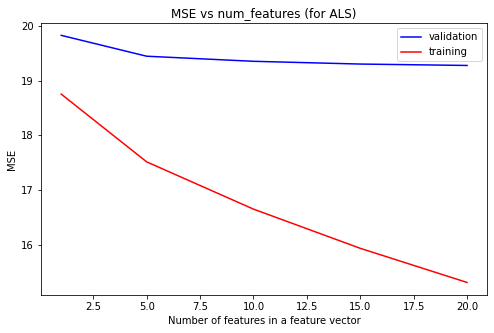

In [44]:
num_features = np.linspace(1,20,5,dtype=int)
test_error_als = []
train_error_als = []
for i in num_features:
    preds_als = als(np.array(train.todense()), k=i, iters = 5)
    test_err = get_mse(preds_als, np.array(val.todense()))
    train_err = get_mse(preds_als, np.array(train.todense()))
    test_error_als.append(test_err)
    train_error_als.append(train_err)

fig = plt.figure(figsize=(8,5))
plt.plot(num_features,test_error_als,'b-',label = 'validation')
plt.plot(num_features,train_error_als,'r-', label = 'training')
plt.title('MSE vs num_features (for ALS)')
plt.xlabel('Number of features in a feature vector')
plt.ylabel('MSE')
plt.legend()

### Refer to [this](https://colab.research.google.com/github/HegdeChaitra/Yelp-Recommendation-System/blob/master/Yelp_Reco_System.ipynb#scrollTo=kAoMx5IHUpsi) for further info